In [59]:
# ライブラリの導入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from biogeme.version import getText # なくても良い（バージョン確認のため導入）
from biogeme.biogeme import BIOGEME
from biogeme.database import Database
from biogeme.expressions import Beta, Variable, log, exp
from biogeme import models
from biogeme.models import loglogit
from biogeme.results_processing import get_pandas_estimated_parameters

In [60]:
# biogemeのバージョン確認
print(getText())

getText is deprecated; use get_text instead.


biogeme 3.3.1 [2025-12-14]
Home page: http://biogeme.epfl.ch
Submit questions to https://groups.google.com/d/forum/biogeme
Michel Bierlaire, Transport and Mobility Laboratory, Ecole Polytechnique Fédérale de Lausanne (EPFL)



In [61]:
# マスターデータの読み込み
master_df = pd.read_csv("/home/shibumtk/B4research/estimate/data/01master_data/Logit_master5.csv", encoding="utf-8-sig")

# 欠損している部分をすべて0で補完（必要な処理は作成時にやってるから大丈夫）
master_df = master_df.fillna(0)

# 男性のみ抽出
solo_df = master_df[master_df["HouseholdType"] == 1]
couple_df = master_df[master_df["HouseholdType"] == 2]
SG_df = master_df[master_df["HouseholdType"] == 3] # SG = second generation（2世代） 


# 確認
print(len(solo_df))
print(len(couple_df))
print(len(SG_df))
solo_df.columns

11713
10083
25976


Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'WorkTime[m]', 'first_transportation',
       'NearestStation', 'NearestStation_code', 'near_area_syou',
       'near_area_kinrin', 'near_area_sum', 'near_area_syou500',
       'near_area_kinrin500', 'near_area_sum500', 'near_area_syou300',
       'near_area_kinrin300', 'near_area_sum300', 'near_o_area_syou',
       'near_o_area_kinrin', 'near_o_area_sum', 'near_o_area_syou500',
       'near_o_area_kinrin500', 'near_o_area_sum500', 'near_o_area_syou300',
       'near_o_area_kinrin300', 'near_o_area_sum300', 'WorkplaceStation',
       'WorkplaceStation_code', 'WP_area_syou', 'WP_area_kinrin',
       'WP_area_sum', 'WP_area_syou500', 'WP_area_kinrin500', 'WP_area_sum500',
       'WP_area_syou300', 'WP_area_kinrin300', 'WP_area_sum300',
       'WP_o_area_syou', 'WP_o_area_kinrin', 'WP_o_area_sum',
       'WP_o_are

In [62]:
# 文字列は除外する
drop_cols =['NearestStation', 'WorkplaceStation']
solo_df = solo_df.drop(columns=drop_cols)
couple_df = couple_df.drop(columns=drop_cols)
SG_df = SG_df.drop(columns=drop_cols)
solo_df.columns

Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'WorkTime[m]', 'first_transportation',
       'NearestStation_code', 'near_area_syou', 'near_area_kinrin',
       'near_area_sum', 'near_area_syou500', 'near_area_kinrin500',
       'near_area_sum500', 'near_area_syou300', 'near_area_kinrin300',
       'near_area_sum300', 'near_o_area_syou', 'near_o_area_kinrin',
       'near_o_area_sum', 'near_o_area_syou500', 'near_o_area_kinrin500',
       'near_o_area_sum500', 'near_o_area_syou300', 'near_o_area_kinrin300',
       'near_o_area_sum300', 'WorkplaceStation_code', 'WP_area_syou',
       'WP_area_kinrin', 'WP_area_sum', 'WP_area_syou500', 'WP_area_kinrin500',
       'WP_area_sum500', 'WP_area_syou300', 'WP_area_kinrin300',
       'WP_area_sum300', 'WP_o_area_syou', 'WP_o_area_kinrin', 'WP_o_area_sum',
       'WP_o_area_syou500', 'WP_o_area_kinrin500', 'WP_o_area

In [63]:
solo_df[['MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdMembers(all)', 'WorkTime[m]', 'near_area_syou300']].describe()

,MainlineTime[m],AccessTime_used[m],HouseholdMembers(all),WorkTime[m],near_area_syou300
count,11713.000000,11713.000000,11713.0,11713.000000,1.171300e+04
mean,49.250552,9.246522,1.0,598.431230,4.890063e+05
std,24.000927,5.946469,0.0,107.281919,4.831955e+05
min,0.000000,0.000000,1.0,240.000000,0.000000e+00
25%,32.512062,5.214216,1.0,550.000000,6.432559e+04
50%,46.117129,8.081342,1.0,590.000000,3.698867e+05
75%,61.473590,11.858271,1.0,656.000000,7.590854e+05
max,336.652190,103.827419,1.0,1185.000000,2.981425e+06


In [64]:
# biogeme.databaseに格納
solo_master_db = Database("PTdata", solo_df)

In [65]:
# 変数（main の DB）
PRITRIP   = Variable("PriTrip")                 # 目的変数（0/1）
MACM_min  = Variable("MainlineTime[m]")         # 本線（分）
WORK_min  = Variable("WorkTime[m]")             # 就業（分）
HHM       = Variable("HouseholdMembers(all)")   # 世帯人数
LU        = Variable("near_area_syou")          # 駅土地利用指標
AT_min    = Variable("AccessTime_used[m]")      # その日の実際の端末時間（分）
MODE      = Variable("first_transportation")    # 1:歩, 2:自転車, 4:バス, 5:車

# スケーリング
MACM_h = solo_master_db.define_variable("MACM_h",  MACM_min / 60)   # /時
WORK_h = solo_master_db.define_variable("WORK_h",  WORK_min / 60)   # /時
LU_s   = solo_master_db.define_variable("LU_s",    LU / 1000000) # 1,000,000㎡あたり
AT_c   = solo_master_db.define_variable("AT_c",    AT_min - np.mean(solo_df["AccessTime_used[m]"])) 

# 各モード利用可否
WALK_AV    = Variable("walk_av")
BICYCLE_AV = Variable("bicycle_av")
BUS_AV     = Variable("bus_av")
CAR_AV     = Variable("car_av")

# モード・ダミー（歩=基準なので作らない）
D_BIC = solo_master_db.define_variable("D_BIC", (MODE == 2))
D_BUS = solo_master_db.define_variable("D_BUS", (MODE == 4))
D_CAR = solo_master_db.define_variable("D_CAR", (MODE == 5))
D_WAL = solo_master_db.define_variable("D_WAL", (MODE == 1)) # 交差項用に使う

# 交差項：端末時間 × モード（4本）
#AT_WAL = master_db.define_variable("AT_WAL", AT_c * D_WAL)
#AT_BIC = master_db.define_variable("AT_BIC", AT_c * D_BIC)
#AT_BUS = master_db.define_variable("AT_BUS", AT_c * D_BUS)
#AT_CAR = master_db.define_variable("AT_CAR", AT_c * D_CAR)

AT_WAL = solo_master_db.define_variable("AT_WAL", AT_min * D_WAL)
AT_BIC = solo_master_db.define_variable("AT_BIC", AT_min * D_BIC)
AT_BUS = solo_master_db.define_variable("AT_BUS", AT_min * D_BUS)
AT_CAR = solo_master_db.define_variable("AT_CAR", AT_min * D_CAR)

# 係数
ASC_YES  = Beta("ASC_YES", 0.0, None, None, 0)
B_MACM   = Beta("B_MACMTIME", -0.01, None, None, 0)  # /時
B_WORK   = Beta("B_WORKTIME", -0.30, None, None, 0)  # /時
B_HH     = Beta("B_HHM_all",  0.0, None, None, 0)
B_LU     = Beta("B_N_EKI_SCORE", 0.0, None, None, 0) # 駅土地利用を入れるなら

# モード・ダミー（歩が基準）→ 定数のずれ
B_D_BIC  = Beta("B_D_BICYCLE", 0.0, None, None, 0)
B_D_BUS  = Beta("B_D_BUS",     0.0, None, None, 0)
B_D_CAR  = Beta("B_D_CAR",     0.0, None, None, 0)

# 端末時間のモード別傾き（/分）
B_AT_WAL = Beta("B_AT_WALK",    -0.01, None, None, 0)
B_AT_BIC = Beta("B_AT_BICYCLE", -0.01, None, None, 0)
B_AT_BUS = Beta("B_AT_BUS",     -0.01, None, None, 0)
B_AT_CAR = Beta("B_AT_CAR",     -0.01, None, None, 0)

In [66]:
# 効用（V_NO=0 を基準に）
V_YES = (ASC_YES
         + B_MACM * MACM_h
         + B_WORK * WORK_h
         #+ B_HH   * HHM
         + B_LU * LU_s   # 利用駅土地利用指標
         + B_D_BIC * D_BIC + B_D_BUS * D_BUS + B_D_CAR * D_CAR
         + B_AT_WAL * AT_WAL + B_AT_BIC * AT_BIC + B_AT_BUS * AT_BUS + B_AT_CAR * AT_CAR)

V = {0: 0, 1: V_YES}

# モデルの推定と結果の表示
# 尤度関数の設定
logprob = loglogit(V, None, PRITRIP)

bio_solo = BIOGEME(solo_master_db, logprob, 
              generate_html=False, generate_yaml=False) # 推定結果保存可否
bio_solo.model_name = "binlogit_mode_dummy_solo"
bio_solo.calculate_null_loglikelihood(avail={0:1, 1:1})
res_solo = bio_solo.estimate()
print(res_solo.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results_solo = get_pandas_estimated_parameters(estimation_results=res_solo)
print(pandas_results_solo)

Results for model binlogit_mode_dummy_solo
Nbr of parameters:		11
Sample size:			11713
Excluded data:			0
Null log likelihood:		-8118.833
Final log likelihood:		-6307.637
Likelihood ratio test (null):		3622.392
Rho square (null):			0.223
Rho bar square (null):			0.222
Akaike Information Criterion:	12637.27
Bayesian Information Criterion:	12718.33

             Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0         ASC_YES  3.436661         0.151554       22.676131    0.000000e+00
1      B_MACMTIME -0.454392         0.062379       -7.284408    3.230749e-13
2      B_WORKTIME -0.411819         0.013867      -29.696817    0.000000e+00
3   B_N_EKI_SCORE  0.018737         0.007122        2.630763    8.519337e-03
4     B_D_BICYCLE  0.233045         0.153989        1.513390    1.301805e-01
5         B_D_BUS  0.311666         0.304388        1.023909    3.058785e-01
6         B_D_CAR  0.166327         0.451622        0.368288    7.126588e-01
7       B_AT_WALK -0.006336       

In [67]:
# biogeme.databaseに格納
couple_master_db = Database("PTdata", couple_df)

In [68]:
# 変数（main の DB）
PRITRIP   = Variable("PriTrip")                 # 目的変数（0/1）
MACM_min  = Variable("MainlineTime[m]")         # 本線（分）
WORK_min  = Variable("WorkTime[m]")             # 就業（分）
HHM       = Variable("HouseholdMembers(all)")   # 世帯人数
LU        = Variable("near_area_syou")          # 駅土地利用指標
AT_min    = Variable("AccessTime_used[m]")      # その日の実際の端末時間（分）
MODE      = Variable("first_transportation")    # 1:歩, 2:自転車, 4:バス, 5:車

# スケーリング
MACM_h = couple_master_db.define_variable("MACM_h",  MACM_min / 60)   # /時
WORK_h = couple_master_db.define_variable("WORK_h",  WORK_min / 60)   # /時
LU_s   = couple_master_db.define_variable("LU_s",    LU / 1000000) # 1,000,000㎡あたり
AT_c   = couple_master_db.define_variable("AT_c",    AT_min - np.mean(couple_df["AccessTime_used[m]"])) 

# 各モード利用可否
WALK_AV    = Variable("walk_av")
BICYCLE_AV = Variable("bicycle_av")
BUS_AV     = Variable("bus_av")
CAR_AV     = Variable("car_av")

# モード・ダミー（歩=基準なので作らない）
D_BIC = couple_master_db.define_variable("D_BIC", (MODE == 2))
D_BUS = couple_master_db.define_variable("D_BUS", (MODE == 4))
D_CAR = couple_master_db.define_variable("D_CAR", (MODE == 5))
D_WAL = couple_master_db.define_variable("D_WAL", (MODE == 1)) # 交差項用に使う

# 交差項：端末時間 × モード（4本）
#AT_WAL = master_db.define_variable("AT_WAL", AT_c * D_WAL)
#AT_BIC = master_db.define_variable("AT_BIC", AT_c * D_BIC)
#AT_BUS = master_db.define_variable("AT_BUS", AT_c * D_BUS)
#AT_CAR = master_db.define_variable("AT_CAR", AT_c * D_CAR)

AT_WAL = couple_master_db.define_variable("AT_WAL", AT_min * D_WAL)
AT_BIC = couple_master_db.define_variable("AT_BIC", AT_min * D_BIC)
AT_BUS = couple_master_db.define_variable("AT_BUS", AT_min * D_BUS)
AT_CAR = couple_master_db.define_variable("AT_CAR", AT_min * D_CAR)

# 係数
ASC_YES  = Beta("ASC_YES", 0.0, None, None, 0)
B_MACM   = Beta("B_MACMTIME", -0.01, None, None, 0)  # /時
B_WORK   = Beta("B_WORKTIME", -0.30, None, None, 0)  # /時
B_HH     = Beta("B_HHM_all",  0.0, None, None, 0)
B_LU     = Beta("B_N_EKI_SCORE", 0.0, None, None, 0) # 駅土地利用を入れるなら

# モード・ダミー（歩が基準）→ 定数のずれ
B_D_BIC  = Beta("B_D_BICYCLE", 0.0, None, None, 0)
B_D_BUS  = Beta("B_D_BUS",     0.0, None, None, 0)
B_D_CAR  = Beta("B_D_CAR",     0.0, None, None, 0)

# 端末時間のモード別傾き（/分）
B_AT_WAL = Beta("B_AT_WALK",    -0.01, None, None, 0)
B_AT_BIC = Beta("B_AT_BICYCLE", -0.01, None, None, 0)
B_AT_BUS = Beta("B_AT_BUS",     -0.01, None, None, 0)
B_AT_CAR = Beta("B_AT_CAR",     -0.01, None, None, 0)

In [69]:
# 効用（V_NO=0 を基準に）
V_YES = (ASC_YES
         + B_MACM * MACM_h
         + B_WORK * WORK_h
         #+ B_HH   * HHM
         + B_LU * LU_s   # 利用駅土地利用指標
         + B_D_BIC * D_BIC + B_D_BUS * D_BUS + B_D_CAR * D_CAR
         + B_AT_WAL * AT_WAL + B_AT_BIC * AT_BIC + B_AT_BUS * AT_BUS + B_AT_CAR * AT_CAR)

V = {0: 0, 1: V_YES}

# モデルの推定と結果の表示
# 尤度関数の設定
logprob = loglogit(V, None, PRITRIP)

bio_couple = BIOGEME(couple_master_db, logprob, 
              generate_html=False, generate_yaml=False) # 推定結果保存可否
bio_couple.model_name = "binlogit_mode_dummies_couple"
bio_couple.calculate_null_loglikelihood(avail={0:1, 1:1})
res_couple = bio_couple.estimate()
print(res_couple.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results_couple = get_pandas_estimated_parameters(estimation_results=res_couple)
print(pandas_results_couple)

Results for model binlogit_mode_dummies_couple
Nbr of parameters:		11
Sample size:			10083
Excluded data:			0
Null log likelihood:		-6989.003
Final log likelihood:		-4064.844
Likelihood ratio test (null):		5848.319
Rho square (null):			0.418
Rho bar square (null):			0.417
Akaike Information Criterion:	8151.687
Bayesian Information Criterion:	8231.092

             Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0         ASC_YES  3.607292         0.177146       20.363435    0.000000e+00
1      B_MACMTIME -0.474271         0.070669       -6.711143    1.931055e-11
2      B_WORKTIME -0.481427         0.016322      -29.495350    0.000000e+00
3   B_N_EKI_SCORE  0.003483         0.010858        0.320772    7.483833e-01
4     B_D_BICYCLE  0.154437         0.257763        0.599143    5.490774e-01
5         B_D_BUS -0.286448         0.333775       -0.858207    3.907779e-01
6         B_D_CAR -0.201249         0.268042       -0.750810    4.527669e-01
7       B_AT_WALK -0.015003   

In [70]:
# biogeme.databaseに格納
SG_master_db = Database("PTdata", SG_df)

In [71]:
# 変数（main の DB）
PRITRIP   = Variable("PriTrip")                 # 目的変数（0/1）
MACM_min  = Variable("MainlineTime[m]")         # 本線（分）
WORK_min  = Variable("WorkTime[m]")             # 就業（分）
HHM       = Variable("HouseholdMembers(all)")   # 世帯人数
LU        = Variable("near_area_syou")          # 駅土地利用指標
AT_min    = Variable("AccessTime_used[m]")      # その日の実際の端末時間（分）
MODE      = Variable("first_transportation")    # 1:歩, 2:自転車, 4:バス, 5:車

# スケーリング
MACM_h = SG_master_db.define_variable("MACM_h",  MACM_min / 60)   # /時
WORK_h = SG_master_db.define_variable("WORK_h",  WORK_min / 60)   # /時
LU_s   = SG_master_db.define_variable("LU_s",    LU / 1000000) # 1,000,000㎡あたり
AT_c   = SG_master_db.define_variable("AT_c",    AT_min - np.mean(SG_df["AccessTime_used[m]"])) 

# 各モード利用可否
WALK_AV    = Variable("walk_av")
BICYCLE_AV = Variable("bicycle_av")
BUS_AV     = Variable("bus_av")
CAR_AV     = Variable("car_av")

# モード・ダミー（歩=基準なので作らない）
D_BIC = SG_master_db.define_variable("D_BIC", (MODE == 2))
D_BUS = SG_master_db.define_variable("D_BUS", (MODE == 4))
D_CAR = SG_master_db.define_variable("D_CAR", (MODE == 5))
D_WAL = SG_master_db.define_variable("D_WAL", (MODE == 1)) # 交差項用に使う

# 交差項：端末時間 × モード（4本）
#AT_WAL = master_db.define_variable("AT_WAL", AT_c * D_WAL)
#AT_BIC = master_db.define_variable("AT_BIC", AT_c * D_BIC)
#AT_BUS = master_db.define_variable("AT_BUS", AT_c * D_BUS)
#AT_CAR = master_db.define_variable("AT_CAR", AT_c * D_CAR)

AT_WAL = SG_master_db.define_variable("AT_WAL", AT_min * D_WAL)
AT_BIC = SG_master_db.define_variable("AT_BIC", AT_min * D_BIC)
AT_BUS = SG_master_db.define_variable("AT_BUS", AT_min * D_BUS)
AT_CAR = SG_master_db.define_variable("AT_CAR", AT_min * D_CAR)

# 係数
ASC_YES  = Beta("ASC_YES", 0.0, None, None, 0)
B_MACM   = Beta("B_MACMTIME", -0.01, None, None, 0)  # /時
B_WORK   = Beta("B_WORKTIME", -0.30, None, None, 0)  # /時
B_HH     = Beta("B_HHM_all",  0.0, None, None, 0)
B_LU     = Beta("B_N_EKI_SCORE", 0.0, None, None, 0) # 駅土地利用を入れるなら

# モード・ダミー（歩が基準）→ 定数のずれ
B_D_BIC  = Beta("B_D_BICYCLE", 0.0, None, None, 0)
B_D_BUS  = Beta("B_D_BUS",     0.0, None, None, 0)
B_D_CAR  = Beta("B_D_CAR",     0.0, None, None, 0)

# 端末時間のモード別傾き（/分）
B_AT_WAL = Beta("B_AT_WALK",    -0.01, None, None, 0)
B_AT_BIC = Beta("B_AT_BICYCLE", -0.01, None, None, 0)
B_AT_BUS = Beta("B_AT_BUS",     -0.01, None, None, 0)
B_AT_CAR = Beta("B_AT_CAR",     -0.01, None, None, 0)

In [72]:
# 効用（V_NO=0 を基準に）
V_YES = (ASC_YES
         + B_MACM * MACM_h
         + B_WORK * WORK_h
         #+ B_HH   * HHM
         + B_LU * LU_s   # 利用駅土地利用指標
         + B_D_BIC * D_BIC + B_D_BUS * D_BUS + B_D_CAR * D_CAR
         + B_AT_WAL * AT_WAL + B_AT_BIC * AT_BIC + B_AT_BUS * AT_BUS + B_AT_CAR * AT_CAR)

V = {0: 0, 1: V_YES}

# モデルの推定と結果の表示
# 尤度関数の設定
logprob = loglogit(V, None, PRITRIP)

bio_SG = BIOGEME(SG_master_db, logprob, 
              generate_html=False, generate_yaml=False) # 推定結果保存可否
bio_SG.model_name = "binlogit_mode_dummies_SG"
bio_SG.calculate_null_loglikelihood(avail={0:1, 1:1})
res_SG = bio_SG.estimate()
print(res_SG.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results_SG = get_pandas_estimated_parameters(estimation_results=res_SG)
print(pandas_results_SG)

Results for model binlogit_mode_dummies_SG
Nbr of parameters:		11
Sample size:			25976
Excluded data:			0
Null log likelihood:		-18005.19
Final log likelihood:		-9035.005
Likelihood ratio test (null):		17940.37
Rho square (null):			0.498
Rho bar square (null):			0.498
Akaike Information Criterion:	18092.01
Bayesian Information Criterion:	18181.82

             Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0         ASC_YES  4.374656         0.130866       33.428457        0.000000
1      B_MACMTIME -0.491886         0.049257       -9.986169        0.000000
2      B_WORKTIME -0.576807         0.012109      -47.634898        0.000000
3   B_N_EKI_SCORE  0.024830         0.009032        2.749205        0.005974
4     B_D_BICYCLE -0.200284         0.104785       -1.911380        0.055956
5         B_D_BUS -0.105896         0.211394       -0.500941        0.616413
6         B_D_CAR -0.125840         0.151778       -0.829110        0.407042
7       B_AT_WALK -0.018116       

# 推定結果の可視化（感度分析）

In [73]:
# 固定値の算出
master_df[["WorkTime[m]", "MainlineTime[m]", "AccessTime_used[m]"]].describe()

,WorkTime[m],MainlineTime[m],AccessTime_used[m]
count,49135.000000,49135.000000,49135.000000
mean,604.004315,56.068516,10.554626
std,108.680044,25.548637,6.716427
min,240.000000,0.000000,0.000000
25%,550.000000,38.086344,5.943449
50%,598.000000,52.895433,9.206132
75%,660.000000,71.187521,13.690621
max,1200.000000,336.652190,202.816762


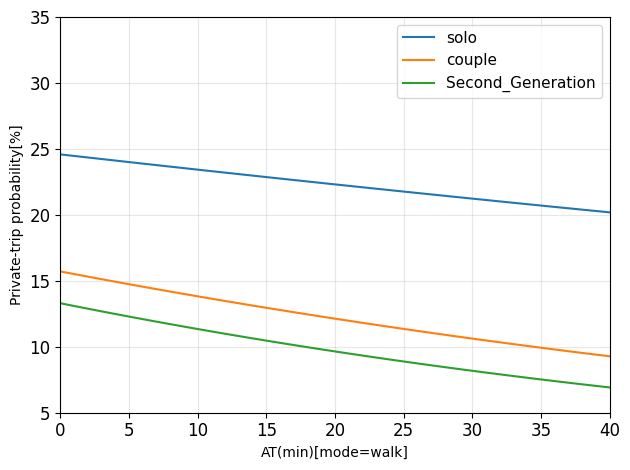

In [81]:
# 男女モデルによる端末時間の感度分析
# 固定値
work_time = master_df["WorkTime[m]"].mean() / 60          # 604分  hours
MACM_h    = master_df["MainlineTime[m]"].mean() / 60      # 56.1分 hours
AccessTime = master_df["AccessTime_used[m]"].mean()       # 10.5分
HHM = 2
lu  = 677535.273703768 / 1e6

# ロジスティクス関数の定義
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# パラメータ値の取得
beta_solo = res_solo.get_beta_values()
beta_couple = res_couple.get_beta_values()
beta_SG = res_SG.get_beta_values()

# 端末時間の変動範囲
AT = np.arange(0, 40.0 + 0.5, 0.5)

def P_walk(beta, AT_array):
    V = (
        beta["ASC_YES"] 
        + beta["B_WORKTIME"] * work_time
        + beta["B_N_EKI_SCORE"] * lu
        + beta["B_MACMTIME"] * MACM_h
        + beta["B_AT_WALK"] * AT_array
    )
    return logistic(V)

P_solo = P_walk(beta_solo, AT)
P_couple = P_walk(beta_couple, AT)
P_SG = P_walk(beta_SG, AT)


# 描画
plt.figure()
plt.plot(AT, P_solo*100, label="solo")
plt.plot(AT, P_couple*100, label="couple")
plt.plot(AT, P_SG*100, label="Second_Generation")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("AT(min)[mode=walk]")
plt.ylabel("Private-trip probability[%]")
plt.xlim(0, 40)
plt.ylim(5, 35)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [75]:
# 具体的な数値を算出
P_solo_5 = P_walk(beta_solo, 5)
P_solo_15 = P_walk(beta_solo, 15)
P_couple_5 = P_walk(beta_couple, 5)
P_couple_15 = P_walk(beta_couple, 15)
P_SG_5 = P_walk(beta_SG, 5)
P_SG_15 = P_walk(beta_SG, 15)
print("単身の端末時間の差", (P_solo_5 - P_solo_15)*100)
print("夫婦の端末時間の差", (P_couple_5 - P_couple_15)*100)
print("2世代の端末時間の差", (P_SG_5 - P_SG_15)*100)

単身の端末時間の差 1.1366167630028845
夫婦の端末時間の差 1.787771797912316
2世代の端末時間の差 1.823163729712235


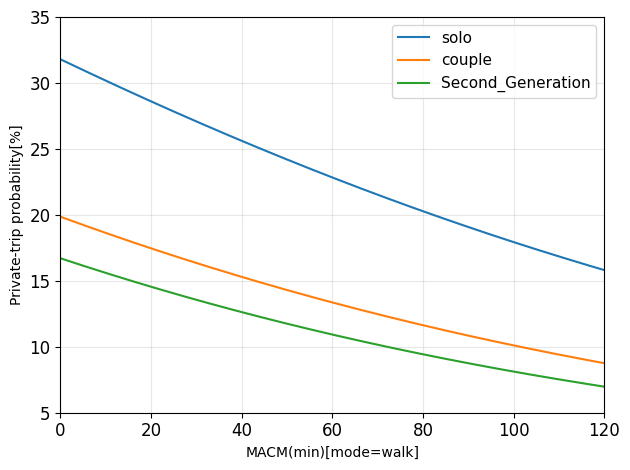

In [82]:
# 男女モデルによるメイン時間の感度分析
# 固定値
work_time = master_df["WorkTime[m]"].mean() / 60          # 604分  hours
MACM_h    = master_df["MainlineTime[m]"].mean() / 60      # 56.1分 hours
AccessTime = master_df["AccessTime_used[m]"].mean()       # 10.5分
HHM = 2
lu  = 677535.273703768 / 1e6

# ロジスティクス関数の定義
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# パラメータ値の取得
beta_solo = res_solo.get_beta_values()
beta_couple = res_couple.get_beta_values()
beta_SG = res_SG.get_beta_values()

# 端末時間の変動範囲
MACM = np.arange(0, 120 + 0.5, 0.5)

def P_MACM(beta, MACM_array):
    V = (
        beta["ASC_YES"] 
        + beta["B_WORKTIME"] * work_time
        + beta["B_N_EKI_SCORE"] * lu
        + beta["B_MACMTIME"] * (MACM_array/60)
        + beta["B_AT_WALK"] * AccessTime
    )
    return logistic(V)

P_solo = P_MACM(beta_solo, MACM)
P_couple = P_MACM(beta_couple, MACM)
P_SG = P_MACM(beta_SG, MACM)


# 描画
plt.figure()
plt.plot(MACM, P_solo*100, label="solo")
plt.plot(MACM, P_couple*100, label="couple")
plt.plot(MACM, P_SG*100, label="Second_Generation")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("MACM(min)[mode=walk]")
plt.ylabel("Private-trip probability[%]")
plt.xlim(0, 120)
plt.ylim(5, 35)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [77]:
# 具体的な数値を算出
P_solo_20 = P_MACM(beta_solo, 20)
P_solo_40 = P_MACM(beta_solo, 40)
P_couple_20 = P_MACM(beta_couple, 20)
P_couple_40 = P_MACM(beta_couple, 40)
P_SG_20 = P_MACM(beta_SG, 20)
P_SG_40 = P_MACM(beta_SG, 40)
print("単身の端末時間の差", (P_solo_20 - P_solo_40)*100)
print("夫婦の端末時間の差", (P_couple_20 - P_couple_40)*100)
print("2世代の端末時間の差", (P_SG_20 - P_SG_40)*100)

単身の端末時間の差 2.9906385889321987
夫婦の端末時間の差 2.1628344852572146
2世代の端末時間の差 1.9226017627999332


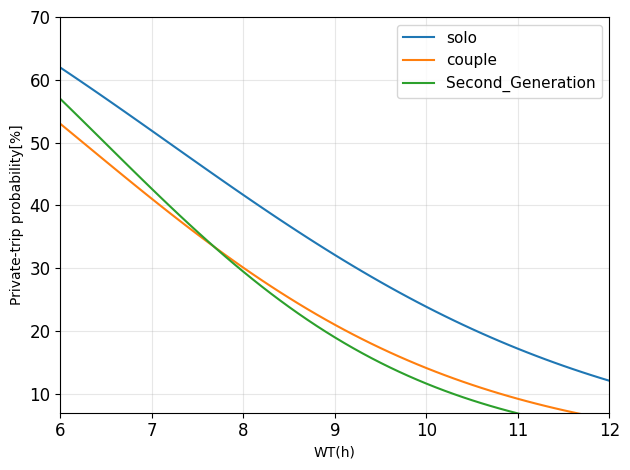

In [78]:
# 男女モデルによる就業時間の感度分析
# 固定値
work_time = master_df["WorkTime[m]"].mean() / 60          # 604分  hours
MACM_h    = master_df["MainlineTime[m]"].mean() / 60      # 56.1分 hours
AccessTime = master_df["AccessTime_used[m]"].mean()       # 10.5分
HHM = 2
lu  = 677535.273703768 / 1e6

# ロジスティクス関数の定義
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# パラメータ値の取得
beta_solo = res_solo.get_beta_values()
beta_couple = res_couple.get_beta_values()
beta_SG = res_SG.get_beta_values()

# 端末時間の変動範囲
WT = np.arange(6, 12 + 0.1, 0.1)

def P_Work(beta, WT_array):
    V = (
        beta["ASC_YES"] 
        + beta["B_WORKTIME"] * WT_array
        + beta["B_N_EKI_SCORE"] * lu
        + beta["B_MACMTIME"] * MACM_h
        + beta["B_AT_WALK"] * AccessTime
    )
    return logistic(V)

P_solo = P_Work(beta_solo, WT)
P_couple = P_Work(beta_couple, WT)
P_SG = P_Work(beta_SG, WT)


# 描画
plt.figure()
plt.plot(WT, P_solo*100, label="solo")
plt.plot(WT, P_couple*100, label="couple")
plt.plot(WT, P_SG*100, label="Second_Generation")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("WT(h)")
plt.ylabel("Private-trip probability[%]")
plt.xlim(6, 12)
plt.ylim(7, 70)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()